In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

LENNA_PATH = "../images/lenna.png"
SHAPE_PATH = "../images/shapes.png"

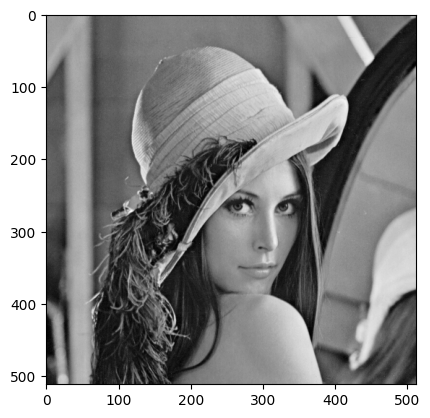

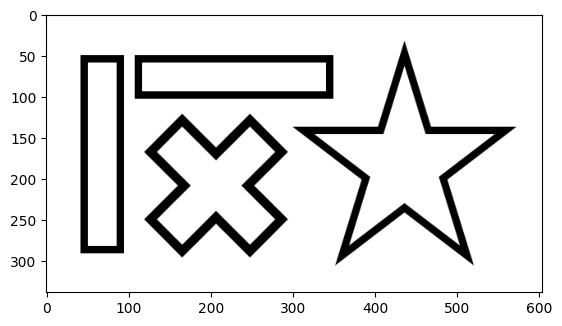

In [4]:
plt.imshow(
    cv2.imread(LENNA_PATH, cv2.IMREAD_GRAYSCALE), 
    cmap = "gray"
)
plt.show()

plt.imshow(
    cv2.imread(SHAPE_PATH, cv2.IMREAD_GRAYSCALE), 
    cmap = "gray"
)
plt.show()

In [5]:
def get_gaussian_filter_1d(size, sigma) :
    kernel = np.arange(size//2 * -1, size//2+1).astype(np.float32).reshape(1, -1)
    kernel = np.exp( -kernel*kernel / (2*sigma*sigma) )
    kernel /= kernel.sum()
    return kernel

def get_gaussian_filter_2d(size, sigma) :
    x_grid, y_grid = np.meshgrid(
        np.arange(-2, 3),
        np.arange(-2, 3)
    )
    distance_square_map = x_grid ** 2 + y_grid ** 2
    kernel = np.exp(-distance_square_map / (2*sigma*sigma))
    kernel /= kernel.sum()
    return kernel


def get_gaussian_filter_2d_using_1d(size, sigma) :
    """
    넘파이 outer 연산을 써도 되는지 안되는지 모르겠어서 이 함수는 안 쓰기로 함
    """
    kernel_1d = get_gaussian_filter_1d(size, sigma)
    kernel = np.outer(kernel_1d, kernel_1d)
    kernel /= kernel.sum()
    return kernel

In [23]:
def cross_correlation_1d(img, kernel) :
    """
    distinguish vertical, horizontal kernel based on the shape of the given kernel
    assume odd sized kernel
    preserve image shape
    
    assume both img and kernel are 1D
    

    """
    img_ = img.reshape(-1)
    kernel_ = kernel.reshape(-1)
    #  vertically stack images
    img_appended = np.vstack(list(map(
        lambda len_shift : img_[
            len_shift : len_shift + len(img_) - len(kernel_) + 1
        ],
        range(len(kernel_))
    )))
    filtered_ = np.matmul(kernel.reshape(1, -1), img_appended).reshape(-1)
    filtered = np.zeros(len(img_)) #, dtype=np.uint8)
    
    # pad  filtered  first
    pad_size = len(kernel_) // 2
    filtered[list(range(pad_size))] = filtered_[0]
    filtered[list(range(pad_size, len(filtered)))] = filtered_[-1]
    # put filtered_  to  filtered
    filtered[pad_size:-pad_size] = filtered_
    
    # check direction of kernel
    if len(kernel.shape) == 1 : # 1D
        filtered = filtered.reshape(1, -1)
    elif len(kernel.shape) == 2 : # 2D.  dimensions over 2D is not considered.
        if kernel.shape[0] > kernel.shape[1] :
            filtered = filtered.reshape(-1, 1)
        else :
            filtered = filtered.reshape(1, -1)
    else :
        pass
    return filtered

def cross_corr_2d_1(img, kernel) :
    img_height, img_width = img.shape
    ker_height, ker_width = kernel.shape
    post_width = img_width - ker_width + 1
    post_hight = img_height - ker_width + 1
    row_pad = kernel.shape[0] // 2
    col_pad = kernel.shape[1] // 2

    filtered = np.zeros(img.shape)
    for i in range(row_pad, row_pad + post_hight) :
        for j in range(col_pad, col_pad + post_width) :
            filtered[i][j] = np.sum(
                img[i-row_pad : i+row_pad+1 ,  j-col_pad : j+col_pad+1 ] * kernel
            )

    filtered[ list(range(row_pad)),:] = filtered[row_pad,:]
    filtered[
        list(range(img_height - row_pad, img_height)), 
        :
    ] = filtered[row_pad + post_hight - 1,:]
    
    filtered[:, list(range(col_pad)) ] = filtered[:,col_pad].reshape(-1, 1)
    filtered[
        :,
        list(range(img_width - col_pad, img_width))
    ] = filtered[:, img_width - col_pad - 1].reshape(-1, 1)

    return filtered

def cross_correlation_2d(img, kernel) :
    """
    """
    return cross_corr_2d_1(img, kernel, 0)

In [19]:
img = np.arange(10)
kernel = np.ones(5, dtype=np.uint8)

print(img, kernel)
cross_correlation_1d(img, kernel)

[0 1 2 3 4 5 6 7 8 9] [1 1 1 1 1]


array([[10., 10., 10., 15., 20., 25., 30., 35., 35., 35.]])

In [25]:
img = np.arange(96).reshape(8, -1)
img = np.ones((10, 10))
kernel = np.ones((5,5))
cross_corr_2d_1(img, kernel)

array([[25., 25., 25., 25., 25., 25., 25., 25., 25., 25.],
       [25., 25., 25., 25., 25., 25., 25., 25., 25., 25.],
       [25., 25., 25., 25., 25., 25., 25., 25., 25., 25.],
       [25., 25., 25., 25., 25., 25., 25., 25., 25., 25.],
       [25., 25., 25., 25., 25., 25., 25., 25., 25., 25.],
       [25., 25., 25., 25., 25., 25., 25., 25., 25., 25.],
       [25., 25., 25., 25., 25., 25., 25., 25., 25., 25.],
       [25., 25., 25., 25., 25., 25., 25., 25., 25., 25.],
       [25., 25., 25., 25., 25., 25., 25., 25., 25., 25.],
       [25., 25., 25., 25., 25., 25., 25., 25., 25., 25.]])